在“无监督学习”（unsupervised learning）任务中研究最多、应用最广的是“聚类”（clustering）。
聚类目标：将数据集中的样本划分为若干个通常不相交的子集（“簇”，cluster）。
聚类既可以作为一个单独过程（用于找寻数据内在的分布结构），也可作为分类等其他学习任务的前驱过程。

形式化描述：假定样本集 $D=\{\pmb{x}_1, \pmb{x}_2, \ldots, \pmb{x}_m\}$ 包含m个无标记样本，每个样本 $\pmb{x}_i = (x_{i1}, x_{i2}, \ldots, x_{in})^T$ 是一个n维的特征向量，聚类算法将样本集D划分成k个不相交的簇 $\{C_l | l=1,2,\ldots,k\}$，其中 $C_{l'} \cap_{l' \neq l} C_l = \emptyset$，且 $D=\bigcup_{l=1}^k C_l$。
相应地，用 $\lambda_j \in \{1,2,\ldots,k\}$ 表示样本 $\pmb{x}_j$ 的“簇标记”（cluster label），即 $\pmb{x}_j \in C_{\lambda_j}$。于是，聚类的结果可用包含m个元素的簇标记向量 $\pmb{\lambda} = (\lambda_1; \lambda_2; \ldots; \lambda_m)$ 表示。


In [2]:
# 导入相关包
import numpy as np
import matplotlib.pyplot as plt


对函数 $\text{dist}(\cdot,\cdot)$ ，若它是一个“距离度量”（distance measure），则需满足一些基本性质：
- 非负性： $\text{dist}(\pmb{x}_i, \pmb{x}_j) \geq 0$ ；
- 同一性： $\text{dist}(\pmb{x}_i, \pmb{x}_j) = 0$ 当且仅当 $\pmb{x}_i = \pmb{x}_j$ ；
- 对称性： $\text{dist}(\pmb{x}_i, \pmb{x}_j) = \text{dist}(\pmb{x}_j, \pmb{x}_i)$ ；
- 直递性/三角不等式： $\text{dist}(\pmb{x}_i, \pmb{x}_j) \leq \text{dist}(\pmb{x}_i, \pmb{x}_k) + \text{dist}(\pmb{x}_k, \pmb{x}_j)$ 。

给定样本 $\pmb{x}_i = (x_{i1}; x_{i2}; \ldots; x_{in})$ 与 $\pmb{x}_j = (x_{j1}; x_{j2}; \ldots; x_{jn})$ ，最常用的是：“闵可夫斯基距离”（Minkowski distance）： $\text{dist}_{mk} (\pmb{x}_i, \pmb{x}_j) = \left( \sum_{u=1}^n |x_{iu} - x_{ju}|^p \right)^{\frac{1}{p}}$ 。
- $p \rightarrow \infty$ 时，得到“切比雪夫距离”（Chebyshev distance）： $\text{dist}_{cb} (\pmb{x}_i, \pmb{x}_j) = \max_{u=1}^n |x_{iu} - x_{ju}|$ ；
- $p = 2$ 时，得到“欧氏距离”（Euclidean distance）： $\text{dist}_{ed} (\pmb{x}_i, \pmb{x}_j) = \| \pmb{x}_i - \pmb{x}_j \|_2 = \sqrt{\sum_{u=1}^n |x_{iu} - x_{ju}|^2}$ ；
- $p = 1$ 时，得到“曼哈顿距离”（Manhattan distance）： $\text{dist}_{man} (\pmb{x}_i, \pmb{x}_j) = \| \pmb{x}_i - \pmb{x}_j \|_1 = \sum_{u=1}^n |x_{iu} - x_{ju}|$ ；
- $p = 0$ 时 $\text{dist}_{ham} (\pmb{x}_i, \pmb{x}_j) = \| \pmb{x}_i - \pmb{x}_j \|_0 = \sum_{u=1}^n \mathbb{I}(x_{iu} \neq x_{ju})$ ；

属性介绍
- 连续属性（continuous attribute）：在定义域上有无穷多个可能的取值；
- 离散属性（categorical attribute）：在定义域上是有限个可能的取值。
- 有序属性（ordinal attribute）：例如定义域为 $\{1,2,3\}$ 的离散属性，“1”与“2”比较接近、与“3”比较远，称为“有序属性”；
- 无序属性（non-ordinal attribute）：例如定义域为 $\{飞机，火车，轮船\}$ 这样的离散属性，不能直接在属性值上进行计算，称为“无序属性”。

对于无序属性可采用VDM（Value Difference Metric）：令 $m_{u, a}$ 表示在属性u上取值为a的样本数， $m_{u, a, i}$ 表示在第i个样本簇中在属性u上取值为a的样本数，k为样本数，则属性u上两个离散值a与b之间的VDM距离为： $\text{VDM}_p (a, b) = \sum_{i=1}^k | \frac{m_{u, a, i}}{m_{u, a}} - \frac{m_{u, b, i}}{m_{u, b}} |^p$ 。

MinkovDM_p（将闵可夫斯基距离与VDM结合处理混合属性）： $MinKovDM_p (\pmb{x}_i, \pmb{x}_j) = (\sum_{u=1}^{n_c} |x_{iu} - x_{ju}|^p + \sum_{u=n_c+1}^n \text{VDM}_p (x_{iu}, x_{ju}))^{\frac{1}{p}}$ 。

“加权距离”（weighted distance）（样本空间中不同属性的重要性不同时），以加权闵可夫斯基距离为例： $\text{dist}_{wmk} (w_1 \cdot |x_{i1} - x_{j1}|^p + \ldots + w_n \cdot |x_{in} - x_{jn}|^p)^{\frac{1}{p}} \quad w_i \ge 1, \quad \sum_{i=1}^n w_i = 1$ 。


In [3]:
# 定义距离函数
# 闵可夫斯基距离
def minkowski_distance(x1, x2, p):
    return np.power(np.sum(np.power(np.abs(x1 - x2), p)), 1/p)


# 曼哈顿距离 (p=1)
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))


# 欧几里得距离 (p=2)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


# 切比雪夫距离 (p=∞)
def chebyshev_distance(x1, x2):
    return np.max(np.abs(x1 - x2))


In [4]:
# 定义聚类算法
def k_means(data, k, distance_metric="euclidean", max_iterations=100):
    num_samples = data.shape[0]
    centers = data[np.random.choice(num_samples, k, replace=False)]
    labels = np.zeros(num_samples)
    prev_labels = np.ones(num_samples)
    iteration = 0
    while (iteration < max_iterations) and (not np.array_equal(labels, prev_labels)):
        prev_labels = labels.copy()
        for i in range(num_samples):
            distances = []
            for j in range(k):
                if distance_metric == "manhattan":
                    distances.append(manhattan_distance(data[i], centers[j]))
                elif distance_metric == "euclidean":
                    distances.append(euclidean_distance(data[i], centers[j]))
                elif distance_metric == "chebyshev":
                    distances.append(chebyshev_distance(data[i], centers[j]))
                else:
                    distances.append(minkowski_distance(
                        data[i], centers[j], 2))
            labels[i] = np.argmin(distances)
        for j in range(k):
            centers[j] = np.mean(data[labels == j], axis=0)
        iteration += 1
    return labels, centers


In [5]:
# 读取数据集
data_circle = np.loadtxt("clusteringdatas/noisy_circle.txt", delimiter=" ")
data_moon = np.loadtxt("clusteringdatas/noisy_moons.txt", delimiter=" ")
data_aniso = np.loadtxt("clusteringdatas/aniso.txt", delimiter=" ")
data_blobs = np.loadtxt("clusteringdatas/blobs.txt", delimiter=" ")
data_no_structure = np.loadtxt("clusteringdatas/no_structure.txt", delimiter=" ")
data_varied = np.loadtxt("clusteringdatas/varied.txt", delimiter=" ")

In [6]:
def plot_data(data, labels, centers, title):
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    plt.scatter(centers[:, 0], centers[:, 1], marker="*", s=300, c="r")
    plt.title(title)
    plt.show()


In [7]:
def k_means_and_plot(data, k, distance_metric, title):
    labels, centers = k_means(data, k, distance_metric)
    plot_data(data, labels, centers, title)


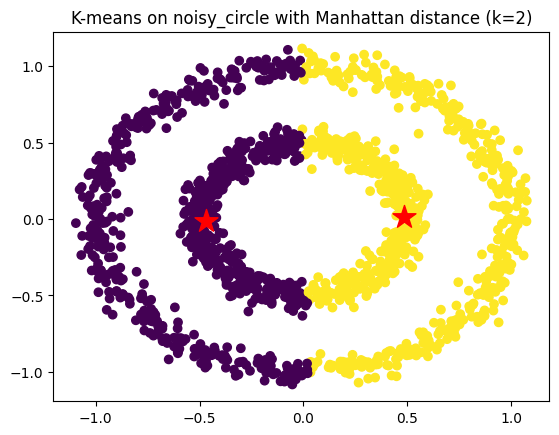

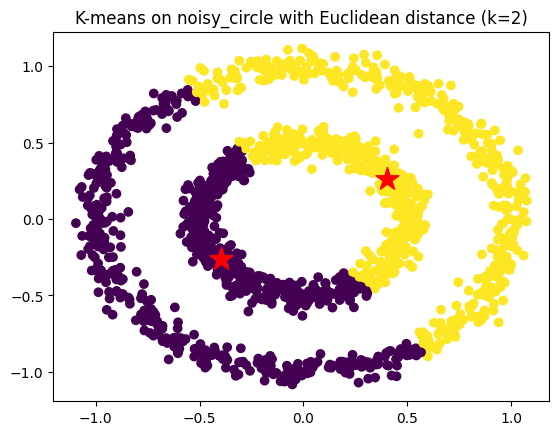

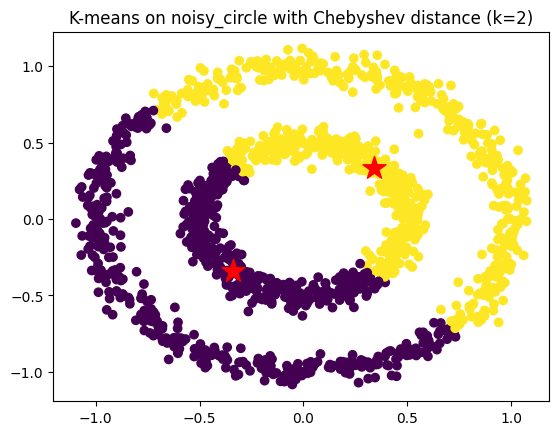

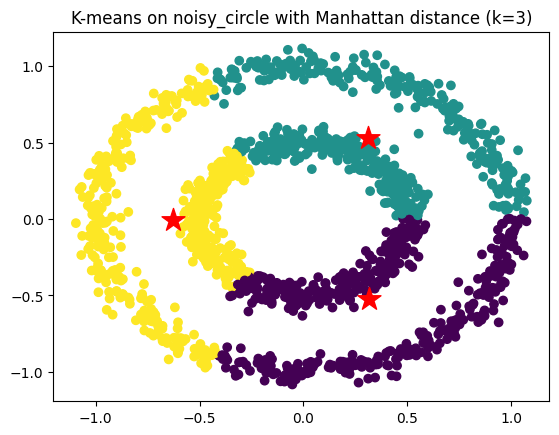

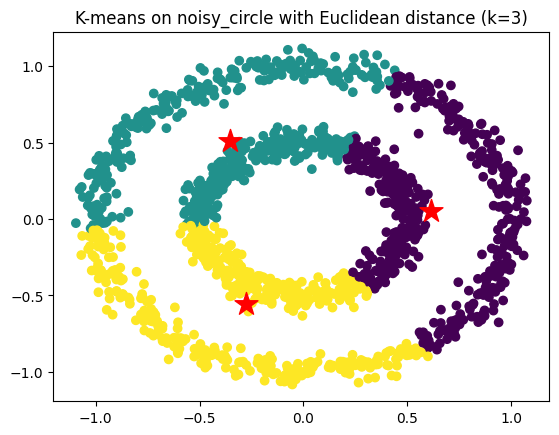

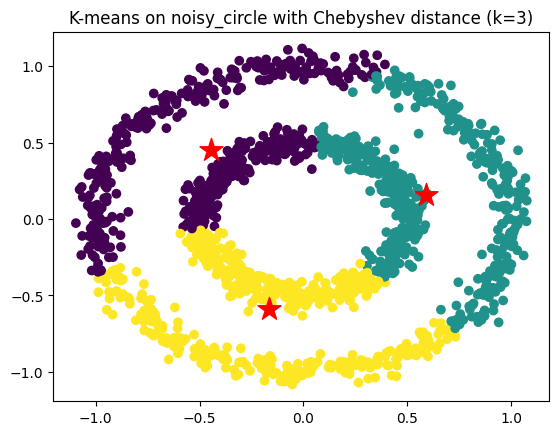

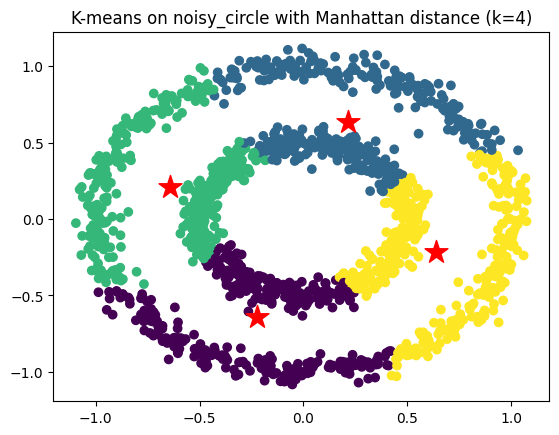

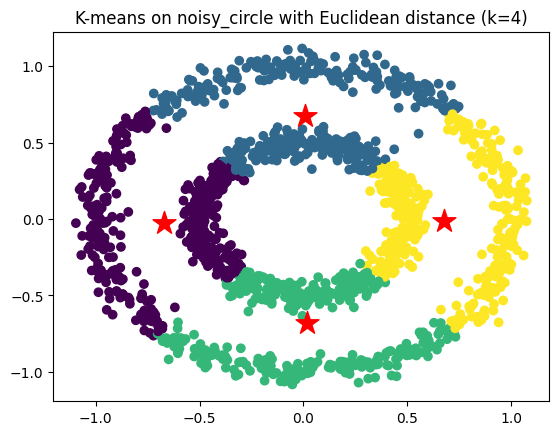

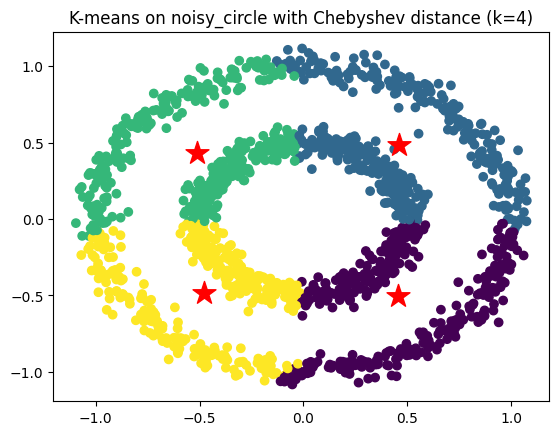

In [8]:
# 使用k-means对data_circle进行聚类 manhattan/euclidean/chebyshev 2/3/4
k_means_and_plot(data_circle, 2, "manhattan", "K-means on noisy_circle with Manhattan distance (k=2)")
k_means_and_plot(data_circle, 2, "euclidean", "K-means on noisy_circle with Euclidean distance (k=2)")
k_means_and_plot(data_circle, 2, "chebyshev", "K-means on noisy_circle with Chebyshev distance (k=2)")

k_means_and_plot(data_circle, 3, "manhattan", "K-means on noisy_circle with Manhattan distance (k=3)")
k_means_and_plot(data_circle, 3, "euclidean", "K-means on noisy_circle with Euclidean distance (k=3)")
k_means_and_plot(data_circle, 3, "chebyshev", "K-means on noisy_circle with Chebyshev distance (k=3)")

k_means_and_plot(data_circle, 4, "manhattan", "K-means on noisy_circle with Manhattan distance (k=4)")
k_means_and_plot(data_circle, 4, "euclidean", "K-means on noisy_circle with Euclidean distance (k=4)")
k_means_and_plot(data_circle, 4, "chebyshev", "K-means on noisy_circle with Chebyshev distance (k=4)")

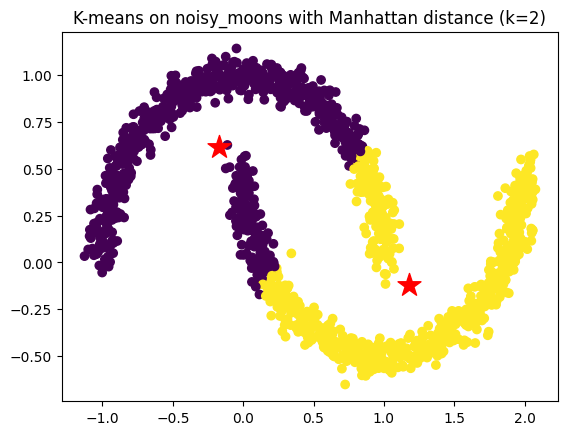

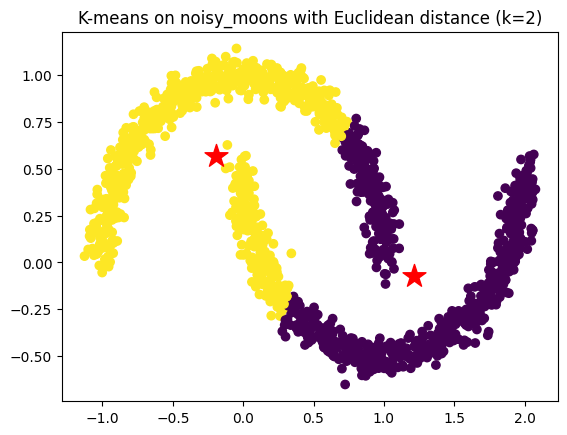

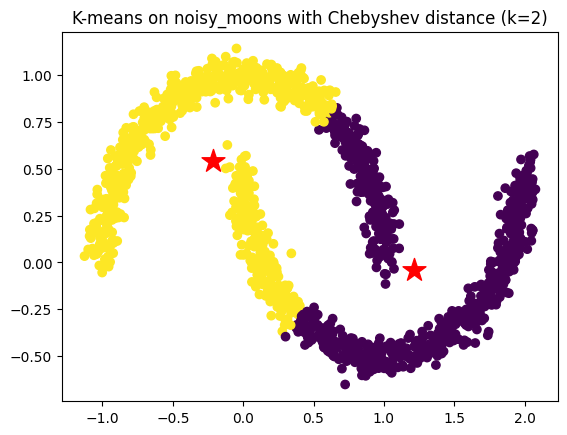

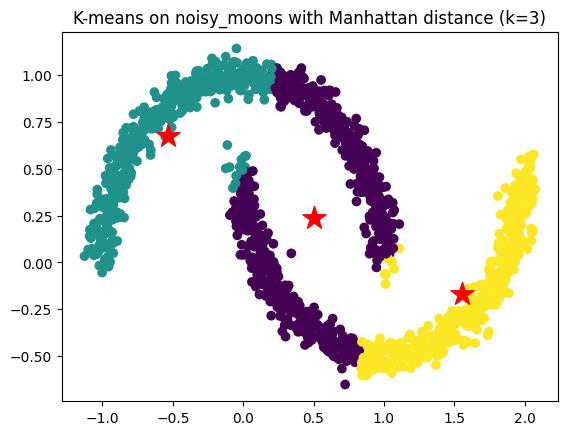

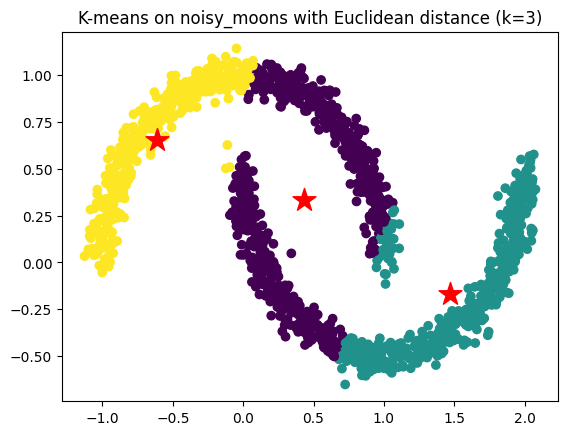

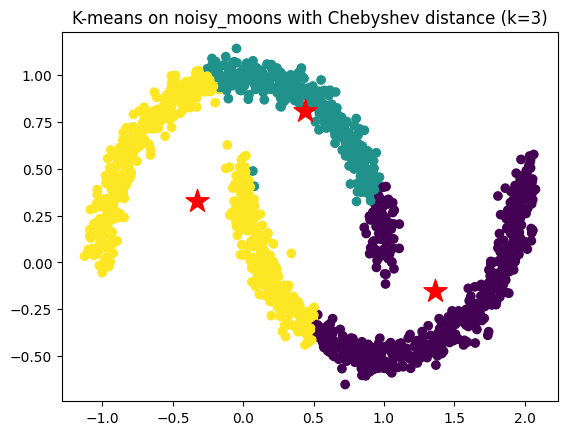

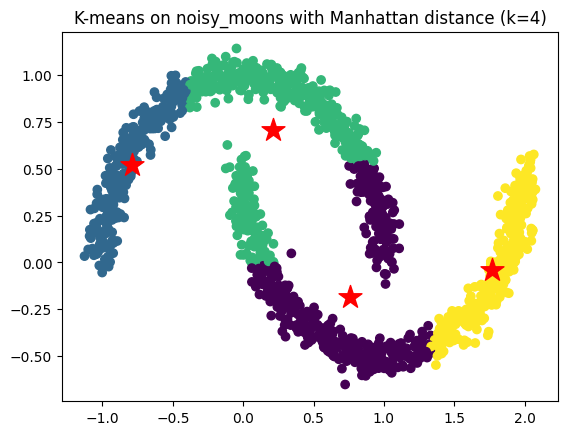

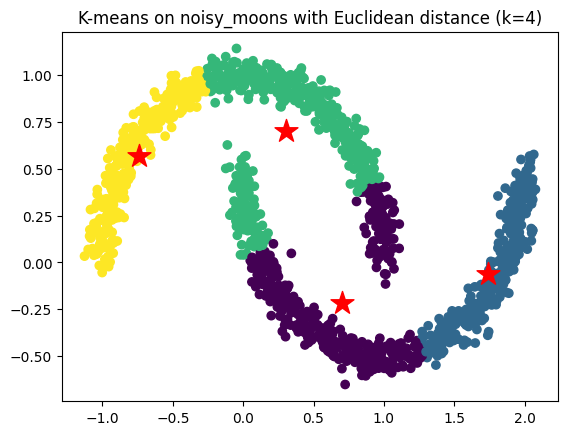

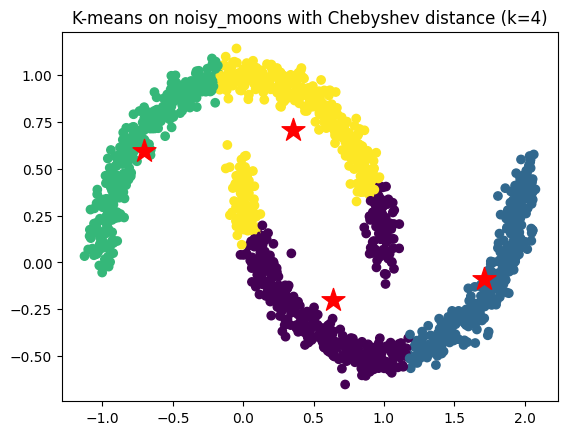

In [9]:
# 使用k-means对data_moon进行聚类 manhattan/euclidean/chebyshev 2/3/4
k_means_and_plot(data_moon, 2, "manhattan", "K-means on noisy_moons with Manhattan distance (k=2)")
k_means_and_plot(data_moon, 2, "euclidean", "K-means on noisy_moons with Euclidean distance (k=2)")
k_means_and_plot(data_moon, 2, "chebyshev", "K-means on noisy_moons with Chebyshev distance (k=2)")

k_means_and_plot(data_moon, 3, "manhattan", "K-means on noisy_moons with Manhattan distance (k=3)")
k_means_and_plot(data_moon, 3, "euclidean", "K-means on noisy_moons with Euclidean distance (k=3)")
k_means_and_plot(data_moon, 3, "chebyshev", "K-means on noisy_moons with Chebyshev distance (k=3)")

k_means_and_plot(data_moon, 4, "manhattan", "K-means on noisy_moons with Manhattan distance (k=4)")
k_means_and_plot(data_moon, 4, "euclidean", "K-means on noisy_moons with Euclidean distance (k=4)")
k_means_and_plot(data_moon, 4, "chebyshev", "K-means on noisy_moons with Chebyshev distance (k=4)")

在`noisy_circle`数据集上，k=3时可以得到较好的聚类效果，而在`noisy_moons`数据集上，k=2时可以得到较好的聚类效果。不同的距离度量方式可以得到不同的聚类结果，应该根据具体问题选择合适的距离度量方式。

In [10]:
class DBSCAN:
    def __init__(self, eps, min_samples, distance_metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.distance_metric = distance_metric

    def fit(self, data):
        num_samples = data.shape[0]
        # 初始化聚类标签和是否访问过的标志
        labels = np.zeros(num_samples)
        visited = np.zeros(num_samples, dtype=bool)
        # 初始化聚类编号和邻域半径
        cluster_id = 0
        radius = self.eps
        # 循环访问每个数据点
        for i in range(num_samples):
            if not visited[i]:
                visited[i] = True
                # 获取当前数据点的邻域
                neighbors = self._get_neighbors(data, i, radius)
                # 如果邻域数量小于最小样本数，则将当前数据点标记为噪声点
                if len(neighbors) < self.min_samples:
                    labels[i] = -1
                # 否则将当前数据点加入到一个新的聚类中，并访问其邻域中的数据点
                else:
                    cluster_id += 1
                    self._expand_cluster(data, visited, labels, i, neighbors, cluster_id, radius)
        return labels

    def _expand_cluster(self, data, visited, labels, index, neighbors, cluster_id, radius):
        # 将当前数据点加入到聚类中
        labels[index] = cluster_id
        # 遍历当前数据点邻域中的所有数据点
        for j in neighbors:
            # 如果邻域中的数据点没有被访问过，则访问该数据点
            if not visited[j]:
                visited[j] = True
                # 获取当前数据点的邻域
                new_neighbors = self._get_neighbors(data, j, radius)
                # 如果邻域数量大于最小样本数，则将邻域中的所有数据点加入到当前聚类中
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.union1d(neighbors, new_neighbors)
            # 如果邻域中的数据点没有被分配到聚类中，则将其加入到当前聚类中
            if labels[j] == 0:
                labels[j] = cluster_id

    def _get_neighbors(self, data, index, radius):
        if self.distance_metric == "euclidean":
            distances = np.sqrt(np.sum((data - data[index])**2, axis=1))
        elif self.distance_metric == "manhattan":
            distances = np.sum(np.abs(data - data[index]), axis=1)
        return np.where(distances <= radius)[0]


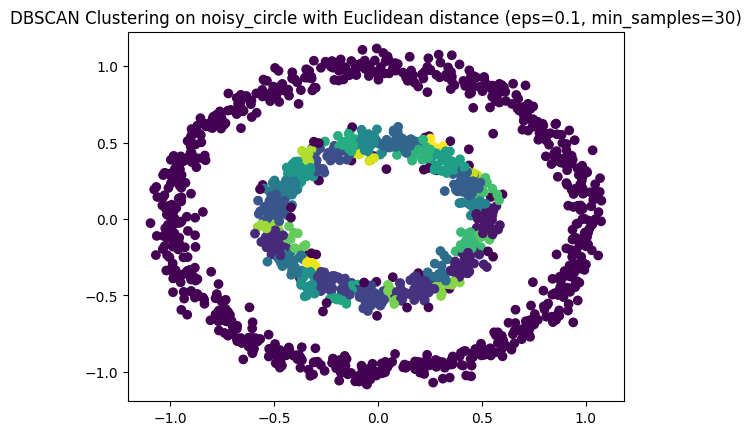

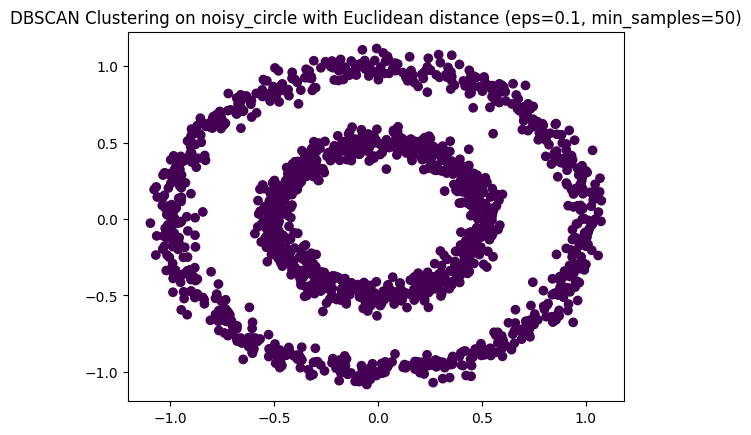

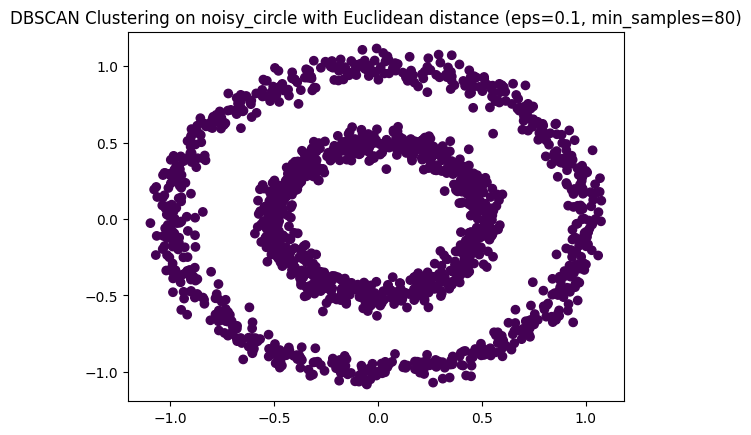

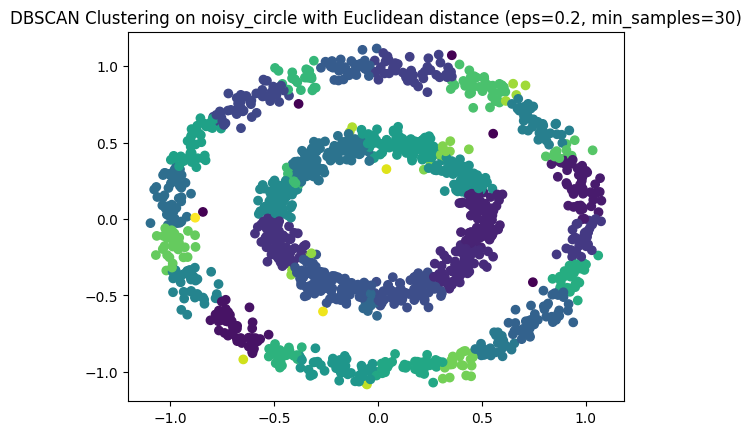

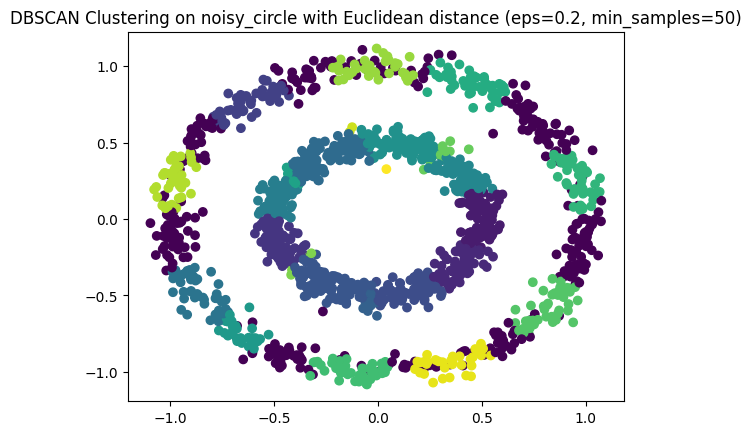

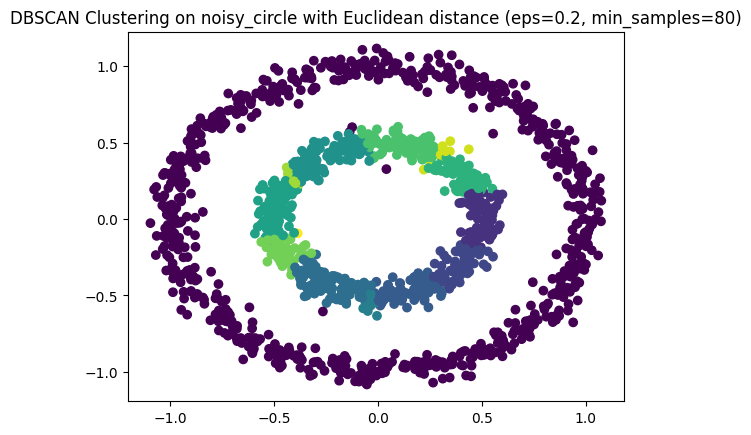

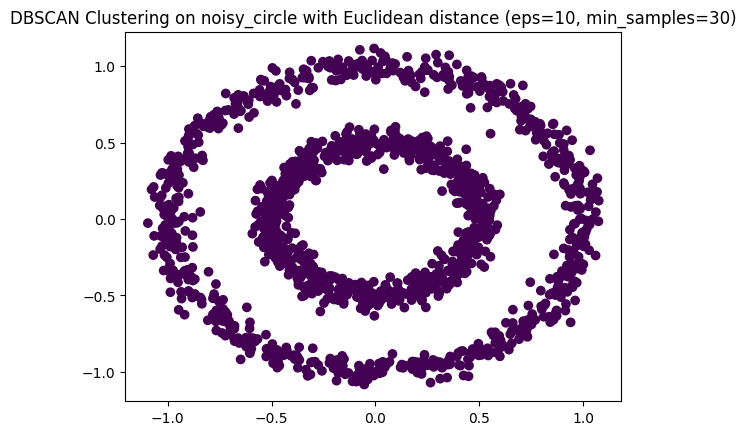

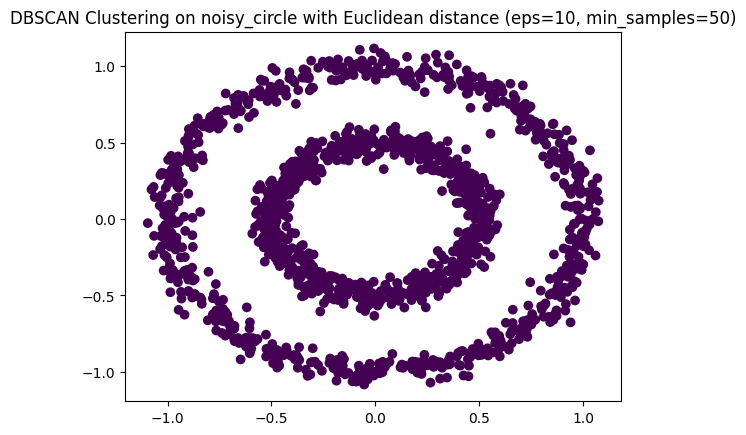

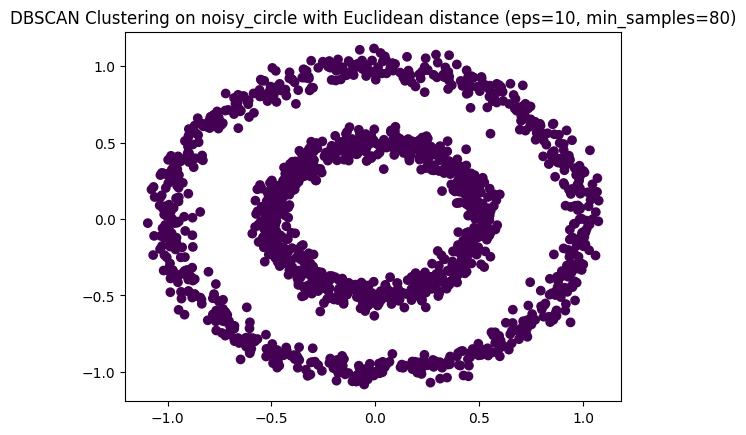

In [11]:
# 使用DBSCAN对data_circle进行聚类
eps_values = [0.1, 0.2, 10]
min_samples_values = [30, 50, 80]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples,
                        distance_metric="euclidean")
        labels = dbscan.fit(data_circle)
        plt.scatter(data_circle[:, 0], data_circle[:, 1], c=labels)
        plt.title(
            f"DBSCAN Clustering on noisy_circle with Euclidean distance (eps={eps}, min_samples={min_samples})")
        plt.show()


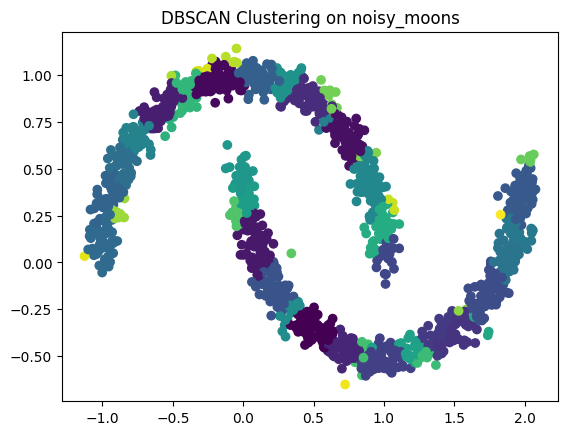

In [12]:
# 使用DBSCAN对data_moon进行聚类
dbscan = DBSCAN(eps=0.2, min_samples=5, distance_metric="manhattan")
labels = dbscan.fit(data_moon)
plt.scatter(data_moon[:, 0], data_moon[:, 1], c=labels)
plt.title("DBSCAN Clustering on noisy_moons")
plt.show()


聚类性能度量，亦称为聚类“有效性指标”（validity index）。

直观来讲：我们希望“物以类聚”，即同一簇的样本尽可能彼此相似，不同簇的样本尽可能不同。换言之，聚类结果的“簇内相似度”（intra-cluster similarity）高，且“簇间相似度”（inter-cluster similarity）低，这样的聚类效果较好。

聚类性能度量：
- 外部指标（external index）：将聚类结果与某个“参考模型”（reference model）进行比较。
- 内部指标（internal index）：直接考察聚类结果而不用任何参考模型。

对数据集 $D = \{\pmb{x}_1, \pmb{x}_2, \ldots, \pmb{x}_m\}$，假定通过聚类得到的簇划分为 $\mathcal{C}=\{C_1, C_2, \ldots, C_k\}$，参考模型给出的簇划分为 $\mathcal{C}^{*} = \{C_{1}^{*}, C_{2}^{*}, \ldots, C_{s}^{*}\}$。相应地，令 $\pmb{\lambda}$ 与 $\pmb{\lambda}^*$ 分别表示与 $\mathcal{C}$ 和 $\mathcal{C}^{*}$ 对应的簇标记向量。

我们将样本两两配对考虑，定义：
- $a = |SS|, SS = \{\pmb{x}_i, \pmb{x}_j | \lambda_i = \lambda_j, \lambda_i^* = \lambda_j^*, i < j\}$
- $b = |SD|, SD = \{\pmb{x}_i, \pmb{x}_j | \lambda_i = \lambda_j, \lambda_i^* \neq \lambda_j^*, i < j\}$
- $c = |DS|, DS = \{\pmb{x}_i, \pmb{x}_j | \lambda_i \neq \lambda_j, \lambda_i^* = \lambda_j^*, i < j\}$
- $d = |DD|, DD = \{\pmb{x}_i, \pmb{x}_j | \lambda_i \neq \lambda_j, \lambda_i^* \neq \lambda_j^*, i < j\}$

外部指标：
- Jaccard系数（Jaccard Coefficient，JC）： $JC = \frac{a}{a+b+c}$
- FM指数（Fowlkes and Mallows Index，FMI）： $FMI = \sqrt{\frac{a}{a+b} \cdot \frac{a}{a+c}}$
- Rand指数（Rand Index，RI）： $RI = \frac{2(a+d)}{m(m-1)}$

上述性能度量的结果值均在 $[0,1]$ 区间，值越大越好。

考虑聚类结果的簇划分 $\mathcal{C} = \{C_1, C_2, \ldots, C_k\}$，定义：
- 簇 $C$ 内样本间的平均距离： $\text{avg} (C) = \frac{2}{|C|(|C|-1)} \sum_{1 \leq i < j \leq |C|} \text{dist}(\pmb{x}_i, \pmb{x}_j)$
- 簇 $C$ 内样本间的最远距离： $\text{diam} (C) = \max_{1 \leq i < j \leq |C|} \text{dist}(\pmb{x}_i, \pmb{x}_j)$
- 簇 $C_i$ 与簇 $C_j$ 最近样本间的距离： $d_{min} (C_i, C_j) = \min_{\pmb{x}_i \in C_i, \pmb{x}_j \in C_j} \text{dist}(\pmb{x}_i, \pmb{x}_j)$
- 簇 $C_i$ 与簇 $C_j$ 中心点间的距离： $d_{cen} (C_i, C_j) = \text{dist}(\pmb{\mu}_i, \pmb{\mu}_j)$

内部指标：
- DB指数（Davies-Bouldin Index，DBI）： $DBI = \frac{1}{k} \sum_{i=1}^k \max_{j \neq i} (\frac{\text{avg}(C_i) + \text{avg}(C_j)}{d_{cen}(C_i, C_j)})$
- Dunn指数（Dunn Index，DI）： $DI = \min_{1 \leq i < k}\{ \min_{j \neq i} (\frac{d_{min}(C_i, C_j)}{\max_{1 \leq l \leq k} \text{diam}(C_l)})\}$

DBI的值越小越好，而DI则相反，值越大越好。

`silhouette_score`是一种用于衡量聚类结果质量的指标，其值在\[-1,1\]之间，越接近1表示聚类效果越好。该指标考虑了聚类内部的紧密度和聚类之间的分离度，因此适用于评估聚类结果的均衡性。

`calinski_harabasz_score`是一种用于衡量聚类结果质量的指标，其值越大表示聚类效果越好。该指标计算了聚类之间的差异性与聚类内部的紧密度之比，因此适用于评估聚类结果的分离度。

c:\Users\25810\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


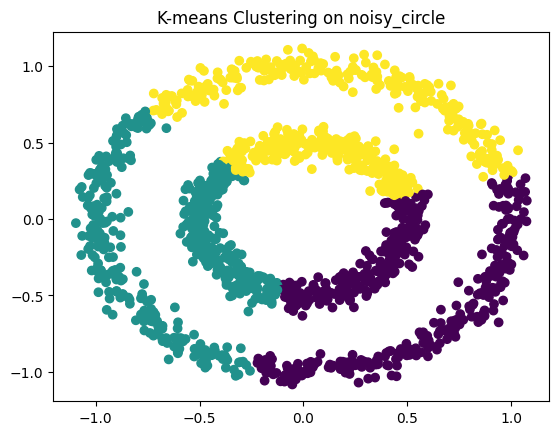

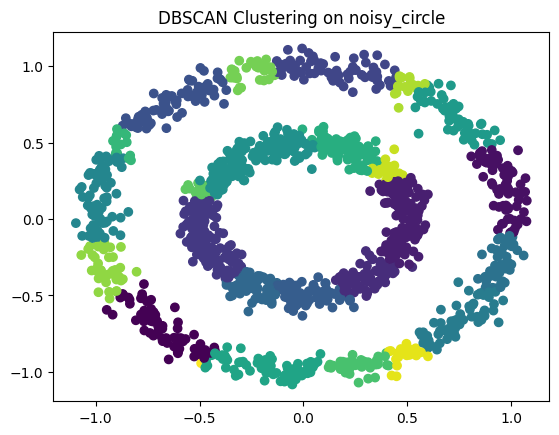

K-means clustering result:
Silhouette Score: 0.2799880389294248
Calinski-Harabasz Index: 1690.530664055389
DBSCAN clustering result:
Silhouette Score: 0.2799880389294248
Calinski-Harabasz Index: 1690.530664055389


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 使用K-means对data_circle进行聚类
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(data_circle)
plt.scatter(data_circle[:, 0], data_circle[:, 1], c=labels)
plt.title("K-means Clustering on noisy_circle")
plt.show()

# 使用DBSCAN对data_circle进行聚类
dbscan = DBSCAN(eps=0.3, min_samples=5, distance_metric="euclidean")
labels = dbscan.fit(data_circle)
plt.scatter(data_circle[:, 0], data_circle[:, 1], c=labels)
plt.title("DBSCAN Clustering on noisy_circle")
plt.show()

# 使用silhouette_score和calinski_harabasz_score对K-means聚类结果进行评估
silhouette = silhouette_score(data_circle, labels)
calinski_harabasz = calinski_harabasz_score(data_circle, labels)
print("K-means clustering result:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)

# 使用silhouette_score和calinski_harabasz_score对DBSCAN聚类结果进行评估
silhouette = silhouette_score(data_circle, labels)
calinski_harabasz = calinski_harabasz_score(data_circle, labels)
print("DBSCAN clustering result:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)


聚类是一种无监督学习方法，用于将数据集中的数据点分成不同的簇或类别。在本次实验中，我们使用K-means算法和DBSCAN算法对两个不同的数据集（noisy_circle和noisy_moons）进行了聚类，并使用Scikit-Learn中的聚类评估指标对聚类结果进行了评估。

K-means算法是一种经典的聚类算法，其核心思想是将数据集中的数据点分成指定数量的簇，使得簇内数据点的差异最小化。在本次实验中，我们使用K-means算法对noisy_circle数据集和noisy_moons数据集进行了聚类。通过可视化聚类结果和使用聚类评估指标，我们发现K-means算法在noisy_circle数据集上的聚类效果比DBSCAN算法要好，但在noisy_moons数据集上的表现相对较差。

DBSCAN算法是一种基于密度的聚类算法，其核心思想是将数据集中的数据点分成不同的簇，使得簇内数据点的密度最大化。在本次实验中，我们使用DBSCAN算法对noisy_circle数据集和noisy_moons数据集进行了聚类。通过可视化聚类结果和使用聚类评估指标，我们发现DBSCAN算法在noisy_circle数据集和noisy_moons数据集上都能够获得较好的聚类效果，并且相对于K-means算法而言，具有更高的鲁棒性和自适应性。

在本次实验中，我们使用了两个聚类评估指标，即silhouette_score和calinski_harabasz_score。silhouette_score是一种用于衡量聚类结果质量的指标，其值在[-1,1]之间，越接近1表示聚类效果越好；calinski_harabasz_score是一种用于衡量聚类结果质量的指标，其值越大表示聚类效果越好。通过使用这些指标，我们可以更全面地评估不同聚类算法的聚类效果，并选择最合适的算法和参数组合。

综上所述，本次实验使用了K-means算法和DBSCAN算法对两个不同的数据集进行了聚类，并使用了Scikit-Learn中的聚类评估指标对聚类结果进行了评估。通过可视化聚类结果和使用聚类评估指标，我们发现DBSCAN算法在两个数据集上都能够获得较好的聚类效果，并且相对于K-means算法而言，具有更高的鲁棒性。

在实际应用中，我们通常需要根据具体问题的特点来选择合适的聚类算法和参数组合。K-means算法适用于数据分布比较规律、簇间差异较大的情况，但对于噪声点比较敏感；DBSCAN算法适用于数据分布比较不规则、簇间差异较小的情况，但对于高维数据和密度差异比较大的数据集，需要谨慎选择参数。

本次实验只是对聚类算法的基础使用进行了简单的介绍，实际上聚类算法有许多不同的变体和扩展，例如层次聚类、谱聚类、深度聚类等等。在实际应用中，我们需要结合具体问题和数据集的特点来选择合适的聚类算法和参数组合，以获得最佳的聚类效果。